In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
import json

# Загрузка (замените на ваш CSV)
df = pd.read_csv('S06-hw-dataset-04.csv')
print(df['target'].value_counts(normalize=True))  # Покажет дисбаланс, напр. 5% positive
X = df.drop(['target', 'id'], axis=1)
y = df['target']


target
0    0.9508
1    0.0492
Name: proportion, dtype: float64


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(pd.Series(y_train).value_counts(normalize=True))  # Проверьте сохранение баланса


target
0    0.950773
1    0.049227
Name: proportion, dtype: float64


In [3]:
# Dummy (stratified лучше most_frequent на дисбалансе)
dummy = DummyClassifier(strategy='stratified', random_state=42)

# LR
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])
# Обучение LR
lr_pipe.fit(X_train, y_train)

# Метрики LR на test
lr_pred = lr_pipe.predict(X_test)
lr_probs = lr_pipe.predict_proba(X_test)[:, 1]

print("LR:",
      "acc=", round(accuracy_score(y_test, lr_pred), 3),
      "f1=", round(f1_score(y_test, lr_pred), 3),
      "pr_auc=", round(average_precision_score(y_test, lr_probs), 3))


LR: acc= 0.779 f1= 0.257 pr_auc= 0.457


In [4]:
models = {
    'tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'rf': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    'gb': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'tree': {'max_depth': [3, 5], 'min_samples_leaf': [10, 20], 'ccp_alpha': [0.001, 0.01]},
    'rf': {'n_estimators': [100, 200], 'max_depth': [5, 10], 'min_samples_leaf': [5, 10]},
    'gb': {'n_estimators': [100], 'max_depth': [3], 'learning_rate': [0.05, 0.1]}
}


In [5]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, RocCurveDisplay

results = {}
best_results = {}
for name, model in models.items():
    print(f"Обучение {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='average_precision', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Сохраняем результаты
    results[name] = {
        'best_params': grid.best_params_,
        'cv_score': grid.best_score_
    }
    
    # Обучаем лучшую модель на полном train
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    
    # Предсказания
    pred = best_model.predict(X_test)
    probs = best_model.predict_proba(X_test)[:, 1]  # Для бинарного: positive class
    
    # Метрики
    metrics = {
        'accuracy': accuracy_score(y_test, pred),
        'f1': f1_score(y_test, pred),
        'roc_auc': roc_auc_score(y_test, probs),
        'pr_auc': average_precision_score(y_test, probs)
    }
    results[name]['test_metrics'] = metrics
    best_results[name] = best_model  # Сохраняем модели
    
    print(f"{name}: PR-AUC={metrics['pr_auc']:.3f}, F1={metrics['f1']:.3f}")

# Лучшая модель (по PR-AUC)
best_name = max(results, key=lambda k: results[k]['test_metrics']['pr_auc'])
best_model = best_results[best_name]
print(f"Лучшая: {best_name}")


Обучение tree...
tree: PR-AUC=0.331, F1=0.374
Обучение rf...
rf: PR-AUC=0.760, F1=0.741
Обучение gb...
gb: PR-AUC=0.732, F1=0.653
Лучшая: rf


Метрики лучшей модели (RF):
Accuracy: 0.977
F1: 0.741
ROC-AUC: 0.900
PR-AUC: 0.760


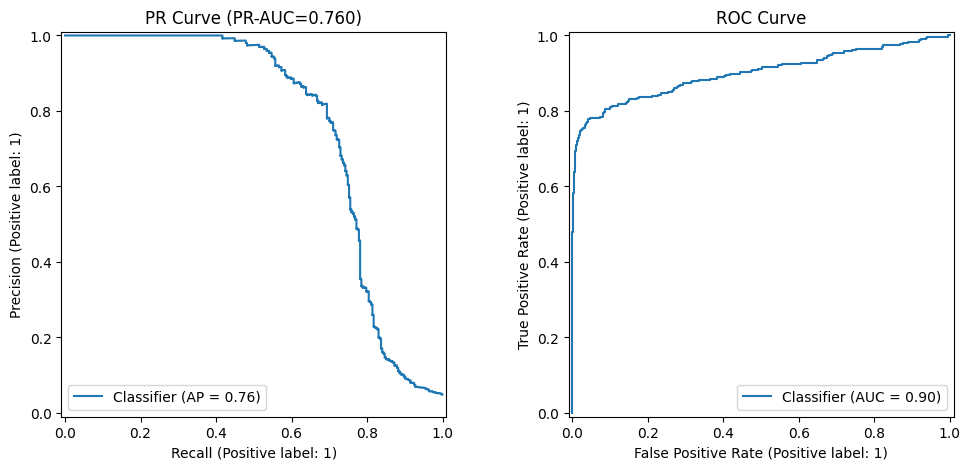

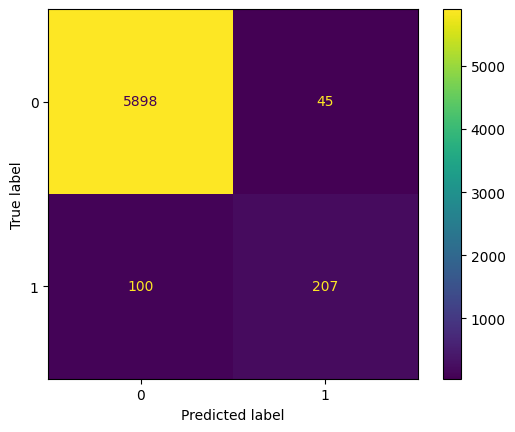

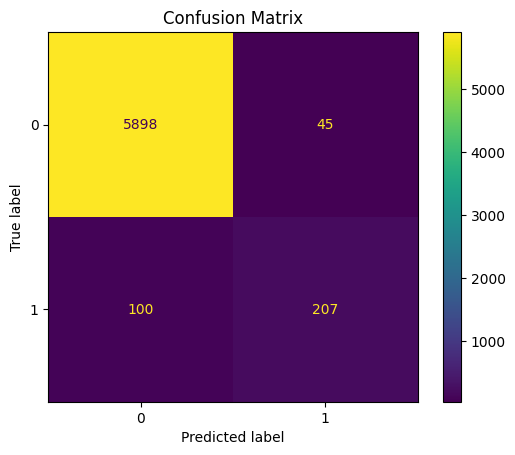


Top-10 признаков:
   feature  importance
53     f54    0.008736
46     f47    0.005792
24     f25    0.005136
12     f13    0.004192
57     f58    0.004160
37     f38    0.003936
52     f53    0.003424
7      f08    0.002416
14     f15    0.002272
3      f04    0.002128


In [6]:
# ===== ГРАФИКИ + АРТЕФАКТЫ (создаст папки) =====
import os
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, accuracy_score, f1_score, roc_auc_score, average_precision_score

# ЛУЧШАЯ МОДЕЛЬ: rf (PR-AUC=0.760)
best_model = best_results['rf']  # Из вашего вывода
pred = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)[:, 1]

print("Метрики лучшей модели (RF):")
print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print(f"F1: {f1_score(y_test, pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, probs):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, probs):.3f}")

# Создаем папки
os.makedirs('artifacts/figures', exist_ok=True)

# График 1: PR + ROC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
PrecisionRecallDisplay.from_predictions(y_test, probs, ax=ax1)
ax1.set_title('PR Curve (PR-AUC=0.760)')
RocCurveDisplay.from_predictions(y_test, probs, ax=ax2)
ax2.set_title('ROC Curve')
plt.savefig('artifacts/figures/pr_roc.png', dpi=150, bbox_inches='tight')
plt.show()

# График 2: Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred).plot()
plt.title('Confusion Matrix')
plt.savefig('artifacts/figures/cm.png', dpi=150, bbox_inches='tight')
plt.show()

# Top-10 features
perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
top_features = pd.DataFrame({
    'feature': X.columns,
    'importance': perm.importances_mean
}).sort_values('importance', ascending=False).head(10)
print("\nTop-10 признаков:")
print(top_features)
top_features.to_csv('artifacts/top_features.csv', index=False)

# Сохранение всего
joblib.dump(best_model, 'artifacts/best_model.joblib')
json.dump(results, open('artifacts/metrics_test.json', 'w'), indent=2)
json.dump({k: v['best_params'] for k, v in results.items()}, open('artifacts/search_summaries.json', 'w'), indent=2)
json.dump({
    'best_model': 'rf',
    'params': results['rf']['best_params'],
    'test_metrics': {'pr_auc': average_precision_score(y_test, probs), 'f1': f1_score(y_test, pred)}
}, open('artifacts/best_model_meta.json', 'w'), indent=2)
